<a href="https://colab.research.google.com/github/hockyy/food-101-mlcv/blob/main/FoodHockyExplore.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive

def import_from_google_drive():
  drive.mount('/content/drive')

import_from_google_drive()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


inserting data set from the donuts folder...


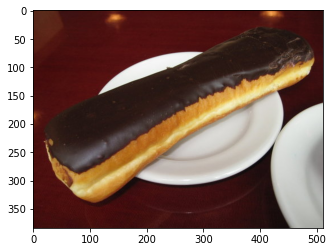

inserting data set from the gnocchi folder...


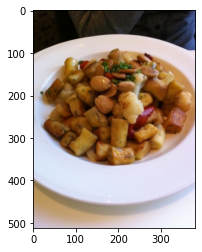

inserting data set from the chicken_curry folder...


In [ ]:
import glob
import cv2
from matplotlib import pyplot as plt
import numpy as np

def read_food_dataset():
  food_path = "/content/drive/MyDrive/mlcv/food-101/*"
  food_directories = glob.iglob(food_path)
  classes = []
  classes_map = dict()
  X_all = []
  y_all = []
  for food_directory in food_directories:
    food_name = food_directory.split('/')[6]
    # Map each food name to each index
    current_label = len(classes)
    classes_map[food_name] = current_label
    classes.append(food_name)
    X_food = []
    y_food = []
    print(f"inserting data set from the {food_name} folder...")
    for food in glob.iglob(f"{food_directory}/*.jpg"):
      image_name = food.split('/')[-1]
      # Read this food image and append it to the array
      food_image = cv2.imread(food)
      food_image = cv2.cvtColor(food_image, cv2.COLOR_BGR2RGB)
      X_food.append(food_image)
      y_food.append(current_label)
    X_all.extend(X_food)
    y_all.extend(y_food)
    plt.imshow(X_food[0])
    plt.show()
  return classes, classes_map, X_all, y_all

classes_food_101, classes_map_food_101, X_food_101, y_food_101 = read_food_dataset()

In [12]:

from sklearn.model_selection import train_test_split
X_train, X_rem, y_train, y_rem = train_test_split(X_food_101, y_food_101, train_size=.8)
X_valid, X_test, y_valid, y_test = train_test_split(X_rem, y_rem, test_size=.5)


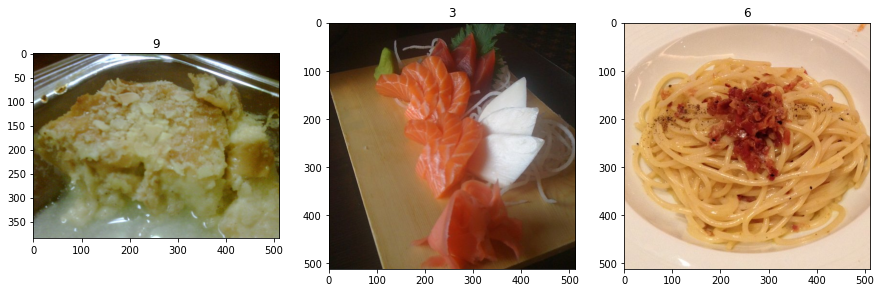

In [11]:
plt.figure(figsize=(15,5))
plt.subplot(1, 3, 1)
plt.title(f"{y_train[0]} {classes_map_food_101[y_train[0]]}")
plt.imshow(X_train[0])
plt.subplot(1,3,2)
plt.title(f"{y_valid[0]} {classes_map_food_101[y_valid[0]]}")
plt.imshow(X_valid[0])
plt.subplot(1,3,3)
plt.title(f"{y_test[0]} {classes_map_food_101[y_test[0]]}")
plt.imshow(X_test[0])
plt.show()